# Titanic Classification Exercise

## Setup and Load the data

In [90]:
# Setup

import os
import pandas as pd
import numpy as np

In [91]:
# Load the data

TITANIC_DATA_PATH = os.path.join("datasets", "titanic")

# This function returns a pandas DataFrame object containing all the data.
def load_titanic_data(filename, data_path=TITANIC_DATA_PATH):
    csv_path = os.path.join(data_path, filename)
    return pd.read_csv(csv_path)

training_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")


Note that the test data does not contain the labels, our goal is to train the best model possible on the training data, then make predictions on the test data, and upload the results to Kaggle.com to see our final score.

## Start to explore and understand the data

In [92]:
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:

- Survived: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
- Pclass: passenger class.
- Name, Sex, Age: self-explanatory
- SibSp: how many siblings & spouses of the passenger aboard the Titanic.
- Parch: how many children & parents of the passenger aboard the Titanic.
- Ticket: ticket id
- Fare: price paid (in pounds)
- Cabin: passenger's cabin number
- Embarked: where the passenger embarked the Titanic

In [93]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Notice: 

Name and Sex are both objects, probably strings. We will probably need to convert these to numerical attributes or drop them (We probably don't need to know the names)

We are missing some values and we will need to deal with those in somehow. We are missing some values for: 
- Age (714/891)
- Cabin (204/891)
- Embarked (889)

I think we should be able to use the median age to fill in the blanks for age, and we can probably drop the 'Cabin' and 'Embarked' categories.

I think we can also drop the PassengerId class for the row index and just remember that it's offset by 1.

In [94]:
# Let's take a deeper look at the numerical attributes next.
training_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- Yikes, only 38% Survived. :( That's close enough to 40%, so accuracy will be a reasonable metric to evaluate our model.
- The mean Fare was £32.20, which does not seem so expensive (but it was probably a lot of money back then).
- The mean Age was less than 30 years old.

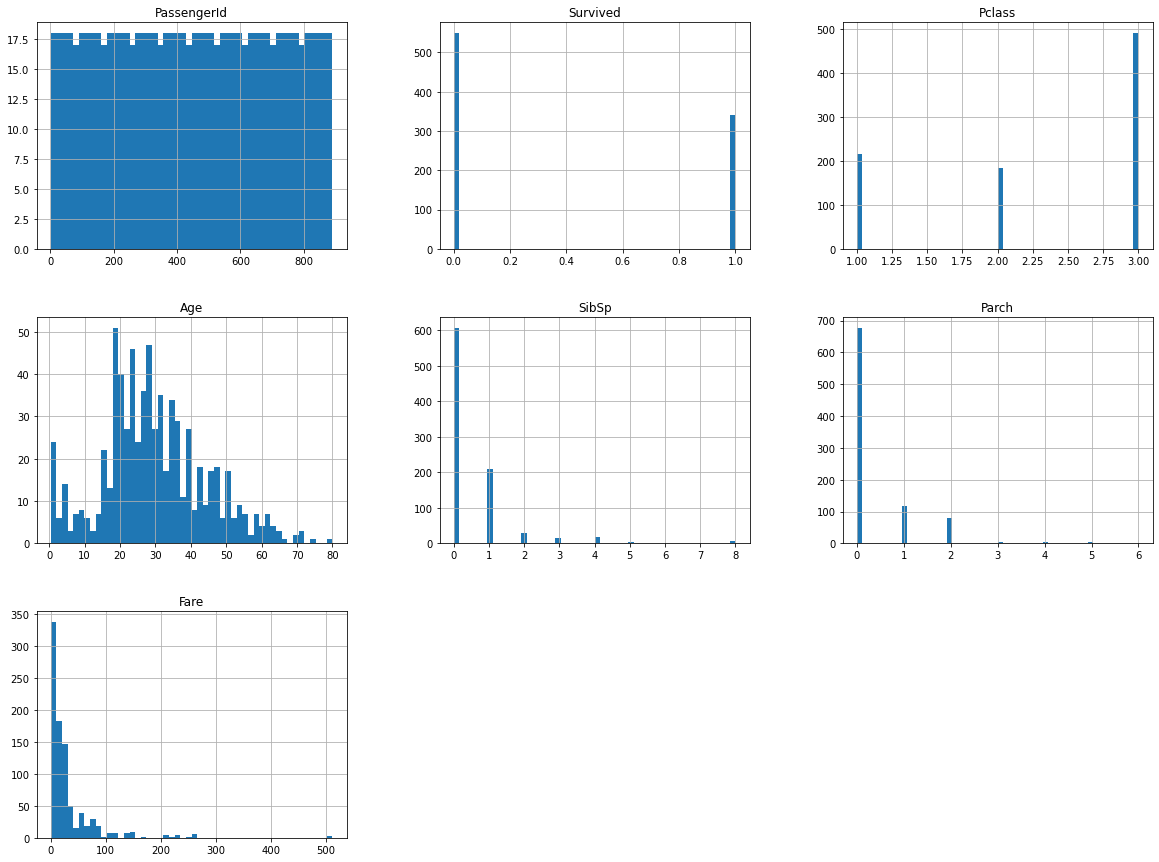

In [95]:
# We can also plot a histogram of each numerical attribute to get a feel for our data
%matplotlib inline
# ^ Jupyter notebook command for inline matplotlib
import matplotlib.pyplot as plt
training_data.hist(bins=50, figsize=(20,15))
plt.show()

In [96]:
# Let's check that if the target 'Survived' is 0 or 1.
training_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [97]:
# Let's take a look at some of the other categorical
training_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [98]:
training_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [99]:
# The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.
training_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

## Preprocessing Pipeline

In [101]:
# We will reuse the DataframeSelector we built in the previous chapter to select specific attributes from the DataFrame:

from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [102]:
# Numerical Attributes Pipeline

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numerical_attributes_pipeline = Pipeline([
        ("select_numerical_attributes", 
            DataFrameSelector(["Pclass", "Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

numerical_attributes_pipeline.fit_transform(training_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

In [104]:
# We will also need an imputer for the string categorical columns (the regular SimpleImputer does not work on those):
# Inspired from stackoverflow.com/questions/25239958

class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [107]:
# Categorical Attributes Pipeline
categorical_attributes_pipeline = Pipeline([
    ("select_categorical_attributes", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
    ("imputer", MostFrequentImputer()),
    ("category_encoder", OneHotEncoder(sparse=False)),
])

categorical_attributes_pipeline.fit_transform(training_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [108]:
# Date Preprocessing Pipeline
from sklearn.pipeline import FeatureUnion

data_preprocess_pipeline = FeatureUnion(transformer_list=[
        ("numerical_attributes_pipeline", numerical_attributes_pipeline),
        ("categorical_attributes_pipeline", categorical_attributes_pipeline),
    ])

In [110]:
# Processed Training Data
X_train = data_preprocess_pipeline.fit_transform(training_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [111]:
# Training Labels
y_train = training_data["Survived"]

## Select and Train a Model

#### SVM Classifier

In [112]:
# Train SVM Classifier
from sklearn.svm import SVC

svm_classifier = SVC(gamma="auto")
svm_classifier.fit(X_train, y_train)

SVC(gamma='auto')

In [114]:
# Evaluate our SVM Classifier Model
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_classifier, X_train, y_train, cv=10)
svm_scores.mean()

0.7329588014981274

In [ ]:
# 73% Accuracy is okay, but we can do better with a more powerful model.

#### Random Forest Classifier

In [117]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_scores = cross_val_score(random_forest_classifier, X_train, y_train, cv=10)
rfc_scores.mean()

0.8126466916354558

In [ ]:
# 81%, that's already a big improvement.

Instead of just looking at the mean accuracy across the 10 cross-validation folds, let's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores (thanks to Nevin Yilmaz for suggesting this visualization). Note that the boxplot() function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is $Q_1$ and the upper quartile is $Q_3$, then the interquartile range $IQR = Q_3 - Q_1$ (this is the box's height), and any score lower than $Q_1 - 1.5 \times IQR$ is a flier, and so is any score greater than $Q3 + 1.5 \times IQR$.

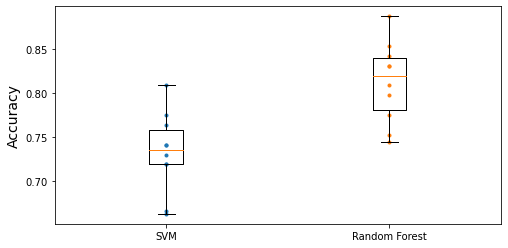

In [119]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, rfc_scores, ".")
plt.boxplot([svm_scores, rfc_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()